In [60]:
import matplotlib.pyplot as plt
import numpy as np
import time
#from lwautils import lwa_arx 
import pandas as pd
#from cr_functions import *
import struct
import math
from lwa_antpos import mapping
import os

In [61]:
def printheader(rawpacketdata):
    #parse the header
    #From MSB to LSB the header is:
    #telescope time: 8 bytes to be interpreted as a 64-bit integer
    headerword=rawpacketdata[-32:]
    print('telescope time',headerword[0:8])

    # 5 bytes zero padding
    print('zero padding',headerword[8:13])

    # 1 byte board id
    print('board id', headerword[13])

    # 1 byte this board triggered
    print('this board triggered', headerword[14])

    # 1 byte coincidence threshold
    print('coincidence threshold', headerword[15])

    # 1 byte veto threshold
    print('veto threshold', headerword[16])

    # 4 bytes (32-bit integer) power threshold for trigger antennas
    print('trigger power threshold', headerword[17:21])

    # 4 bytes (32-bit integer) power threshold for veto antennas
    print('veto power threshold', headerword[21:25])

    # 2 bytes (16 bit integer) coincidence window
    print('coincidence window',headerword[25:27])

    # 2 bytes (16 bit integer) veto window
    print('veto coincidence window',headerword[27:29])

    # 1 byte antenna id
    print('antenna id', headerword[29])

    # 1 byte trigger role
    print('trigger role', headerword[30])

    # 1 byte veto role
    print('veto role',headerword[31])
    return

def parseheader(rawpacketdata):
    #rawpacketdata is the entire raw data payload previously extracted from a cosmic ray udp packet
    #returns a dictionary containing the metadata from the packet header, which it should be noted is the last 256 bits
    headerword=rawpacketdata[-32:]

    headerdictionary={}
    headerdictionary['timestamp'] = struct.unpack('>Q',headerword[0:8])
    headerdictionary['board_id'] = int(headerword[13])
    headerdictionary['this_board_triggered'] =  int(headerword[14])
    headerdictionary['coincidence_threshold'] =  int(headerword[15])
    headerdictionary['veto_threshold'] =  int(headerword[16])
    headerdictionary['trigger_power_threshold'] = struct.unpack('>I',headerword[17:21])
    headerdictionary['veto_power_threshold'] = struct.unpack('>I',headerword[21:25])
    headerdictionary['coincidence_window'] = struct.unpack('>H',headerword[25:27])
    headerdictionary['veto_coincidence_window'] = struct.unpack('>H',headerword[27:29])
    headerdictionary['antenna_id'] =  int(headerword[29])
    headerdictionary['trigger_role'] = int(headerword[30])
    headerdictionary['veto_role'] = int(headerword[31])
    return headerdictionary

def parseheaderbytes(headerword):
    #this function turns the 256-bit header word from the packet data payload into a dictionary
    headerdictionary={}
    headerdictionary['timestamp'] = struct.unpack('>Q',headerword[0:8])
    headerdictionary['board_id'] = int(headerword[13])
    headerdictionary['this_board_triggered'] =  int(headerword[14])
    headerdictionary['coincidence_threshold'] =  int(headerword[15])
    headerdictionary['veto_threshold'] =  int(headerword[16])
    headerdictionary['trigger_power_threshold'] = struct.unpack('>I',headerword[17:21])
    headerdictionary['veto_power_threshold'] = struct.unpack('>I',headerword[21:25])
    headerdictionary['coincidence_window'] = struct.unpack('>H',headerword[25:27])
    headerdictionary['veto_coincidence_window'] = struct.unpack('>H',headerword[27:29])
    headerdictionary['antenna_id'] =  int(headerword[29])
    headerdictionary['trigger_role'] = int(headerword[30])
    headerdictionary['veto_role'] = int(headerword[31])
    return headerdictionary

def unpackdata(rawpacketdata,datatype):
    nbytes=len(rawpacketdata)
    unpackeddata=np.zeros(int((nbytes-32)/2),dtype=datatype)
    #unpackeddata=[]
    for i in range(int((nbytes-32)/2)):
        value=struct.unpack(datatype,rawpacketdata[(2*i):(2*i +2)]) #read a pair of bytes as an integer. Last 32 bytes are header
        unpackeddata[i]=value[0] 
    return unpackeddata


def parsefile(fname):
    #get data and header from a file with raw data from an arbitrary number of cosmic ray packets
    with open(fname, mode="rb") as datafile:
         rawfiledata = datafile.read()
    metadata=[] #list of header dictionaries
    if len(rawfiledata)%8192: 
        print("File contains incomplete packets")
        return
    else:
        npackets=len(rawfiledata)//8192
        print("File contains ",npackets," packets")
        timeseries=np.zeros((npackets,4096-16))
        for p in range(npackets):
            rawpacketdata=rawfiledata[8192*p:8192*(p+1)]
            metadata.append(parseheader(rawpacketdata))
            timeseries[p]=unpackdata(rawpacketdata,'>h')
    return metadata,timeseries

def packet_ant_id_2_snap_input(i):
    #This function returns the snap input number corresponding to a packet with integer i in the antenna_id field in the packet header
    #someday the need for this remapping could probably be addressed in the firmware
    return (i&0b111000)+((i+1)&0b000111)


## Examine the multi-packet files

In [62]:
counterfiles=['/home/ubuntu/kp/data/newpacketizer/cosmic_ray_system_2023-03-23_1205/counter1679614319.2388244.dat']

constantsfiles=['/home/ubuntu/kp/data/newpacketizer/cosmic_ray_system_2023-03-23_1205/constant1679614293.2181191.dat']

File contains  64  packets
(15046321677,)
(15046321677,)
antenna ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


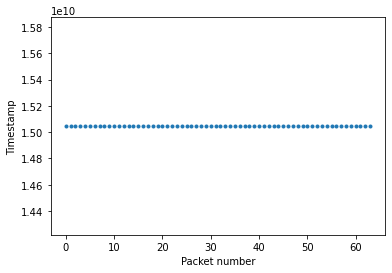

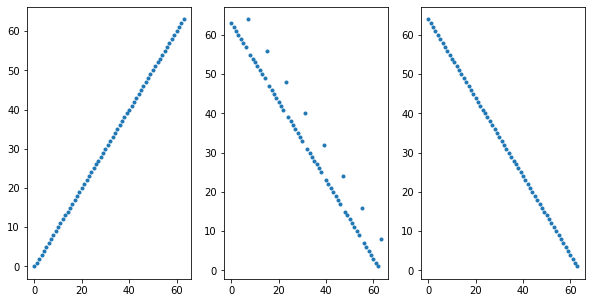

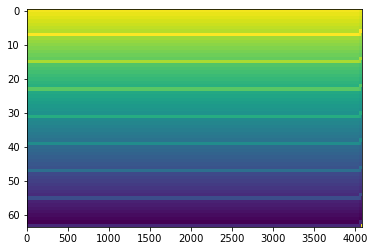

In [66]:
for constantsfile in constantsfiles:

    fname=constantsfile
    metadata,timeseries=parsefile(fname)
    antenna_ids=[headerdict['antenna_id'] for headerdict in metadata] 
    timestamps= [headerdict['timestamp'] for headerdict in metadata] 
    
    plt.figure()
    plt.plot(timestamps,'.')
    plt.ylabel("Timestamp")
    plt.xlabel("Packet number")
    print(min(timestamps))
    print(max(timestamps))
    plt.figure(figsize=(10,5))
    plt.subplot(131)
    plt.plot(antenna_ids,'.')
    plt.subplot(132)
    plt.plot(antenna_ids,timeseries[:,1000],'.')
    plt.subplot(133)
    plt.plot([packet_ant_id_2_snap_input(a) for a in antenna_ids],timeseries[:,1000],'.')
    print("antenna ids",antenna_ids)
    
    plt.figure()
    plt.imshow(timeseries,aspect='auto',interpolation='none')
    
    '''print("Not in timeseries")
    for a in range(66):
        if a not in timeseries[:,1000]:
            print(a)

    print("Not in antenna ids")
    for a in range(66):
        if a not in antenna_ids:
            print(a)

    print("Not in timeseries at start")
    for a in range(66):
        if a not in timeseries[:,0]:
            print(a)'''

File contains  64  packets
(17853912659,)
(17853912659,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
-439.0
-439.0


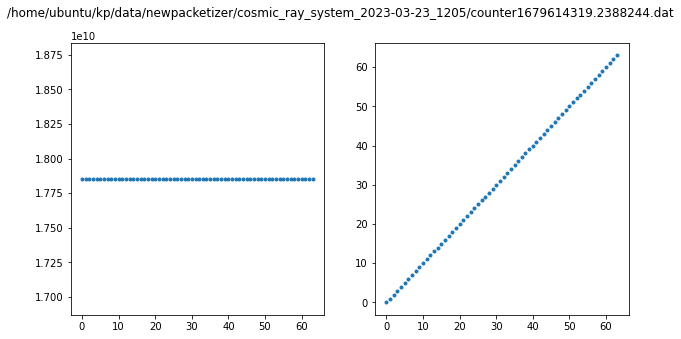

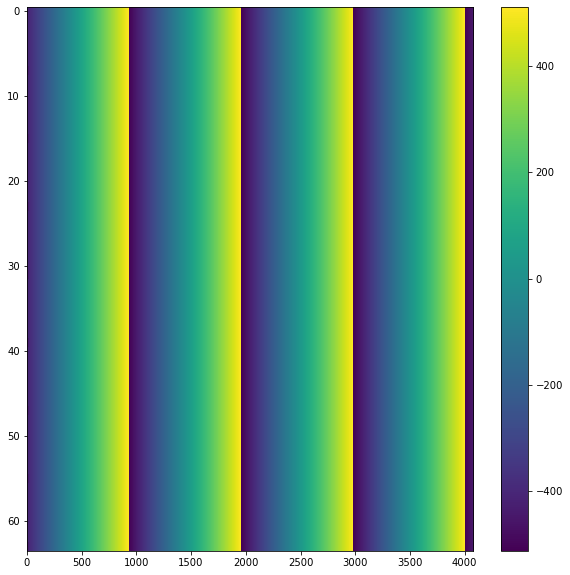

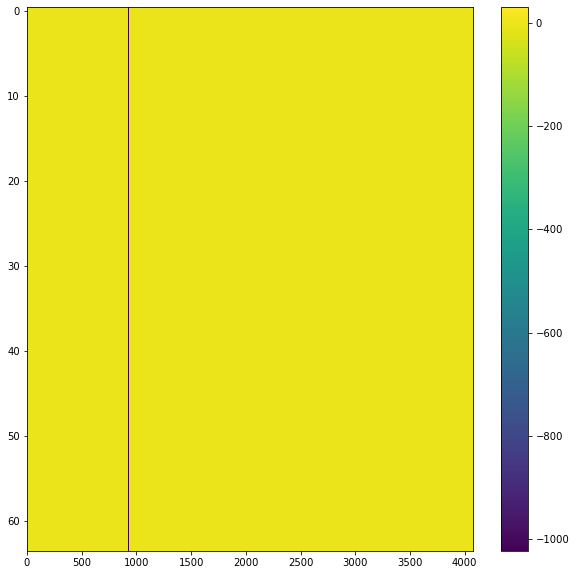

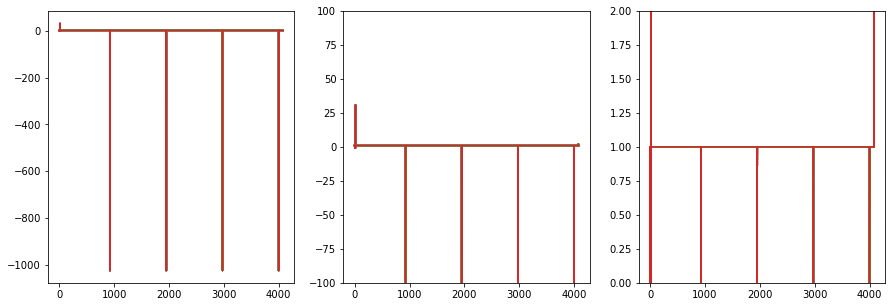

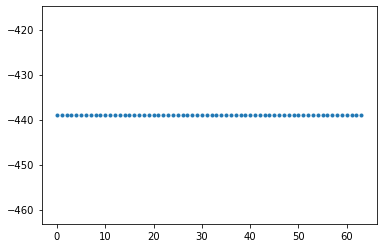

In [115]:
for fname in counterfiles:
    metadata,timeseries=parsefile(fname)
    antenna_ids=[headerdict['antenna_id'] for headerdict in metadata] 
    timestamps= [headerdict['timestamp'] for headerdict in metadata]

    plt.figure(figsize=(10,5))
    plt.suptitle(fname)
    plt.subplot(121)
    plt.plot(timestamps,'.')
    print(min(timestamps[0:-1]))
    print(max(timestamps[0:-1]))
    plt.subplot(122)
    plt.plot(antenna_ids,'.')
    print(antenna_ids)
    plt.figure(figsize=(10,10))
    plt.imshow(timeseries,aspect='auto',interpolation='none')
    plt.colorbar()
    plt.figure(figsize=(10,10))
    derivatives=timeseries[:,1:] - timeseries [:,:-1]
    plt.imshow(derivatives,aspect='auto',interpolation='none')
    plt.colorbar()

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    for i in range(64):
        plt.plot(derivatives[i])
    plt.subplot(132)
    for i in range(64):
        plt.plot(derivatives[i])
    plt.ylim(-100,100)

    plt.subplot(133)
    for i in range(64):
        plt.plot(derivatives[i])
    plt.ylim(0,2)

    plt.figure()
    plt.plot(timeseries[:,1000],'.')
    print(timeseries[12,1000])
    print(timeseries[13,1000])

(-550.0, -300.0)

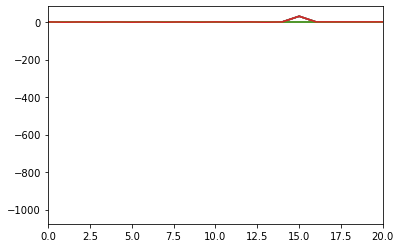

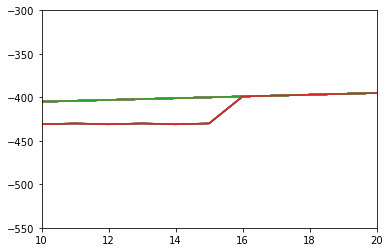

In [128]:
plt.figure()
for i in range(64):
    plt.plot(derivatives[i])
plt.xlim(0,20)
plt.figure()
for i in range(64):
    plt.plot(timeseries[i])
plt.xlim(10,20)
plt.ylim(-550,-300)

## Examine long-counter snapshot

In [130]:
def parselongcounter(timeseries):
    pass
    return
def packetid2snapinput(antid):
    #Map the antenna id field in a cosmic ray packet to the corresponding input
    pass
    return

File contains  64  packets


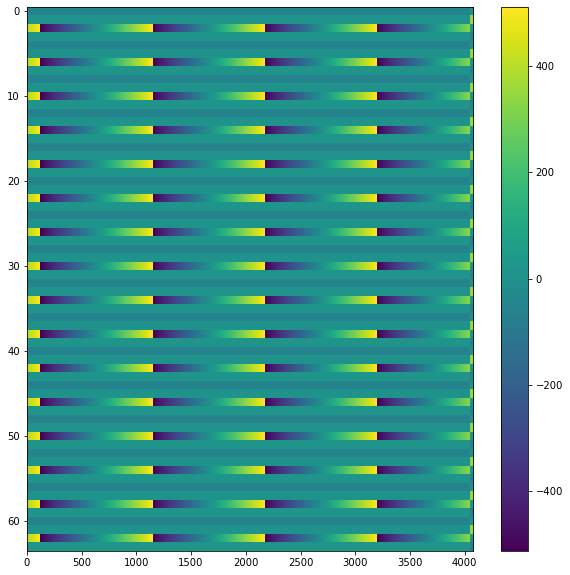

In [131]:
longcounterfiles=['/home/ubuntu/kp/data/newpacketizer/cosmic_ray_system_2023-03-23_1205/longcounter1679614340.6337419.dat']
for fname in longcounterfiles:
    metadata,timeseries=parsefile(fname)
    antenna_ids=[headerdict['antenna_id'] for headerdict in metadata] 
    timestamps= [headerdict['timestamp'] for headerdict in metadata]


    plt.figure(figsize=(10,10))
    plt.imshow(timeseries,aspect='auto',interpolation='none')
    plt.colorbar()




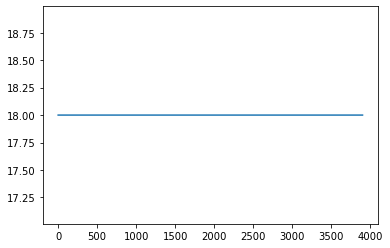

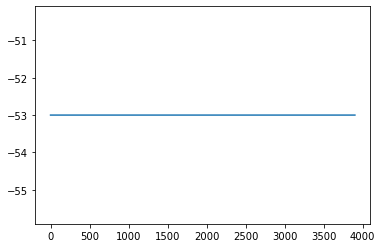

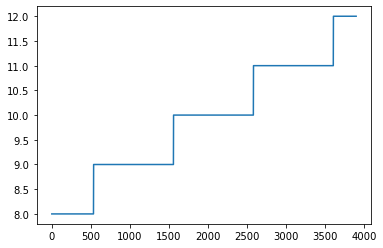

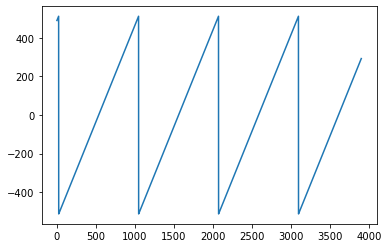

In [132]:
plt.figure()
plt.plot(timeseries[3,100:4000])

plt.figure()
plt.plot(timeseries[4,100:4000])

plt.figure()
plt.plot(timeseries[5,100:4000])

plt.figure()
plt.plot(timeseries[6,100:4000])

In [133]:
def signed2unsigned10bvalue(i):
    #calculate the value of the unsigned 10 bit integer that would have the same bits as the 10-bit signed representation of the input
    if i<0:
        return ((2**10)+i)
    else:
        return i
           
def merge2(msbs,lsbs):
    #piece together the twenty least significant bits of the long counter test signal
    n=len(msbs)
    merged=np.zeros(n)
    for i in range(n):
        msb10u=signed2unsigned10bvalue(msbs[i])
        lsb10u=signed2unsigned10bvalue(lsbs[i])
        merged[i]=(msb10u*1024)+lsb10u
    return merged
            

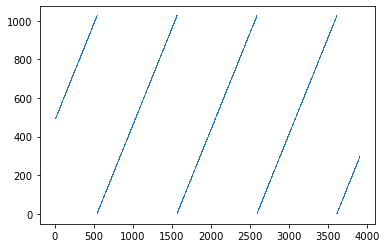

In [134]:
plt.plot([signed2unsigned10bvalue(i) for i in timeseries[6,100:4000]],',')

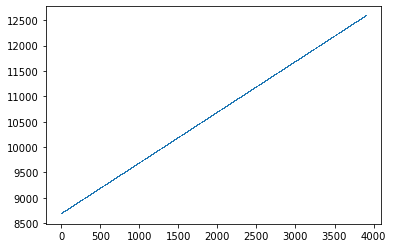

In [135]:
plt.plot(merge2(timeseries[5,100:4000],timeseries[6,100:4000]),',')

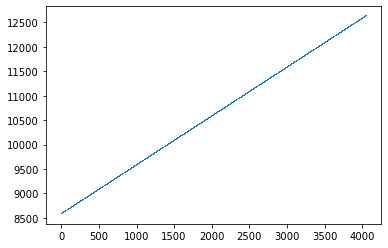

In [136]:

end= -32
plt.plot(merge2(timeseries[5,:end],timeseries[6,:end]),',')